# CS 316 : Introduction to Deep Learning - Fall 2024
## Lab 04 : Linear Regression
### Dr. Abdul Samad

# Instructions

1. Make a copy of this notebook on google colab at start of the lab.

2. Please rename your notebook as *Lab_4_aa1234.ipynb* before starting the lab. Notebooks which do not follow appropriate naming convention will not be graded.

3. You have to submit this lab during the lab timings. You are allowed to submit till 11:59 PM on the day of your lab with a 30% penalty. No submissions will be accepted afterwards.

4. Use of AI is strictly prohibited. Anyone caught using Any AI tool during lab or while grading will be immediately reported to OCVS without any further discussion.

5. At the end of the lab, download the notebook (ipynb extension file) and upload it on canvas as a file. Submitting link to notebook or any other file will not be accepted.

6. Each task has points assigned to it. Total Lab is of 100 points.

7. Use of for loops is strictly prohibited.

8. For every theoretical question, there is a separate cell given at the end. You have to write your answer there.

9. If you have any questions, please feel free to reach out to the course instructor or RA.

## Task Overview


So far we have studied about how input layers are connected to hidden neurons and then to output. But we haven't completely applied it on any dataset. We are going to do that in this lab today. Lab is pretty short but at the same time necessary for you as this will help you to understand the full cycle.

## Setup

In [1]:
# Importing the essentials
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import os
import random
import urllib.request
import pandas as pd
from keras.datasets import fashion_mnist,cifar10,mnist
np.random.seed(42)

2024-09-20 14:38:37.508037: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-20 14:38:37.718381: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-20 14:38:37.917467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-20 14:38:38.081760: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-20 14:38:38.132981: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-20 14:38:38.433971: I tensorflow/core/platform/cpu_feature_gu

## [20 Points] Task 01 - Download Dataset

A suitable dataset is required in order to obtain a linear regression model with reasonable accuracy. There are numerous datasets available, and many of them can be found online. You can also download the dataset manually, but scripting its retrieval is more convenient and may save time.
We'll use the urllib.request package to download the dataset.

In [2]:
# TODO: Complete get_dataset
def get_dataset(filename):
    """
    Download the boston housing dataset.
    If the file already exists, don't download the data again.
    Add appropriate error handling as well.

    Args:
        filename (string): The path where you want to save the file.
    Return:
        bool : True, if you successfully downloaded the data. False,  if the file already exists.
    """
    # Write your code here.
    # BEGIN SOLUTION
    if os.path.exists(filename):
        return False
    else:
        urllib.request.urlretrieve('https://raw.githubusercontent.com/plotly/datasets/master/auto-mpg.csv', filename)
        return True
    # END SOLUTION

In [3]:
# DO NOT EDIT
# TEST CODE FOR CHECKING THE FUNCTION.
if not os.path.isdir("datasets"):
  os.mkdir("datasets")
housing_csv = os.path.join("datasets", "data.csv")
if os.path.exists(housing_csv):
  assert get_dataset(housing_csv) == False
else:
  assert get_dataset(housing_csv) == True

## Exploratory Data Analysis

After downloading the csv file, let's observe the data and try to understand what it means.

In [4]:
# DO NOT EDIT
# Load the dataset
housing_dataset = pd.read_csv(housing_csv)
# View the top rows of the dataset
housing_dataset.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model-year
0,18.0,8,307.0,130.0,3504,12.0,70
1,15.0,8,350.0,165.0,3693,11.5,70
2,18.0,8,318.0,150.0,3436,11.0,70
3,16.0,8,304.0,150.0,3433,12.0,70
4,17.0,8,302.0,140.0,3449,10.5,70


Most of the variables are unlikely to have a significant impact on Chance of admit. To avoid dealing with irrelevant columns, try finding out which variables have strong correlation with data. It has been done in below given code. No need to do it for now. Since all variables have strong connection, we are not dropping any column for now.

/tmp/ipykernel_82061/4166014523.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


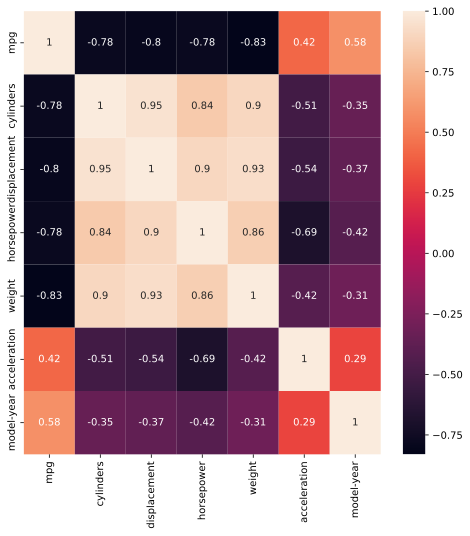

In [5]:
# DO NOT EDIT
%matplotlib inline
display.set_matplotlib_formats('svg')
plt.figure(figsize=(8,8))
correlation_matrix = housing_dataset.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

### In some ases, the some columns don't correlate with our output. We drop those columns before training. This is part of data cleaning. In this case, we are not dropping any columns. Try exploring how will you drop some columns from thie heatmap after submitting lab at your home.

In [6]:
# DO NOT EDIT
# Extract only the relevant columns. X: Input, Y: Output
# iloc specifies the position of the column we want to select. :, part means all rows. ,-1 means last column
output = housing_dataset.iloc[:,-2]
print(housing_dataset.columns)
Y = np.array(output.values).reshape(-1,1)
X = np.array(housing_dataset.drop(columns=['mpg'],axis=1))
print(Y.shape,X.shape)

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model-year'],
      dtype='object')
(398, 1) (398, 6)


## [20 Points] Task 02 - Train Test Split

To determine whether regression is effective, we can split our data into a training and test set and compare performance. Before splitting data, make sure to shuffle it because data is sometimes arranged in a specific order, such as all low-end houses first. If the data is not properly shuffled, it may fail to learn patterns. So, to avoid bias in your training data, shuffle it before splitting.

**Your task is to split the dataset into training and test dataset by completing the function `train_test_split(inputs,outputs,test_size,seed)`**

**Important note on seed**: Reproducability is extremely important. Sometimes, you might find a good seed for a split. When dealing with random shuffling, you will get different results everytime you run. You can set a global seed by using `np.random.seed(42)` however that sets the global seed. It is useful over here to not change the global seed here, since if you want to reproduce the same result, you will have to run the entire code again. The solution to this problem is that you create a generator with a specific seed and use that for generation. [You can find more about setting seeds here](https://builtin.com/data-science/numpy-random-seed)

In [7]:
# TODO: Complete train_test_split
def train_test_split(inputs,outputs,test_size,seed = 0):
    """
    Splits the data into training and test sets.
    Return 4 numpy arrays. X_train, X_test, Y_train, Y_test
    where training data is test_size proportion of data provided.

    Args:
        inputs [np.array] : numpy array of input data
        outputs [np.array]: numpy array of output labels
        test_size [float]: proportion of data to be used as test data. e.g. 0.2 means 20% of data is used for test data.
        seed [int]: A seed to create random number generator. (For reproducability)
    """
    rng = np.random.default_rng(seed)
    assert(len(inputs) == len(outputs))
    assert(test_size <= 1.0)
    assert(test_size >= 0.0)
    num_samples = len(inputs)
    num_train = int(num_samples * (1.0 - test_size))
    # Write your code here
    # Create index using np.arange
    # Shuffle the dataset using rng.shuffle
    # Split the dataset into train, test
    # BEGIN SOLUTION
    indices = np.arange(num_samples)
    rng.shuffle(indices)
    train_indices = indices[:num_train]
    test_indices = indices[num_train:]
    X_train = inputs[train_indices]; X_test = inputs[test_indices]
    Y_train = outputs[train_indices]; Y_test = outputs[test_indices]
    # END SOLUTION
    return X_train, X_test, Y_train, Y_test

In [8]:
# DO NOT EDIT
# TEST CODE FOR CHECKING THE FUNCTION.
x_input = np.array([1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0])
y_output = np.array([3,4,5,6,7,8,9,10,11,12])
seed = 0
split = 0.5
x_train,x_test,y_train,y_test = train_test_split(x_input,y_output,split,seed)
print(f'x_train: {x_train}, x_test: {x_test}, y_train: {y_train}, y_test: {y_test}')
assert np.allclose(x_train,np.array([5.0,7.0,3.0,8.0,4.0]))
assert np.allclose(x_test,np.array([6.0,10.0,1.0,9.0,2.0]))
assert np.allclose(y_train,np.array([ 7,  9,  5, 10,  6]))
assert np.allclose(y_test,np.array([8,12,3,11,4]))

x_train: [5. 7. 3. 8. 4.], x_test: [ 6. 10.  1.  9.  2.], y_train: [ 7  9  5 10  6], y_test: [ 8 12  3 11  4]


To understand how we can use regression for this dataset have a look at these set of equations you would have used previously.


# RELU Activation Function

In [9]:
# DO NOT EDIT
def ReLU(preactivation):
  activation=np.where(preactivation>=0,preactivation,0)
  return activation

def relu_derivative(x):
  return np.where(x > 0, 1, 0)

## [20 Points] Task 03 - Deep Neural Network Model



Before we performming operations, we must define our model, relating its inputs and parameters to its outputs. Recall that to calculate the output of the  model, we simply take the matrix-vector dot product of the input features $\mathbf{x}$ and the model weights ($\mathbf{\theta_1}$), and add the offset (also called bias or $\theta_0$) to each example. Then we apply activation function to it and pass it to next layer.


For your lab, you will be building a neural network with 3 hidden layers. First layer has 2 neurons, second has 3 and 3rd has 2. There will be 1 output layer. However, the dimension of input layer is something which depends on dataset. You need to find that out.




**In this task you are required to initialse the model weights and bias (thetas) by implementing the function `initialise_model`.**
You have to initialize weights and biases using np.random.randn function. Scale your weights with a factor of 0.01 after initialization as input values are of that range.

In [10]:
# TODO: Complete initialise_model
def initialise_model(input_size,hidden_size1,hidden_size2,hidden_size3,output_size):
    """
    Args:
        input_size: Size of the input layer
        hidden_size1: Size of the first hidden layer
        hidden_size2: Size of the second hidden layer
        output_size: Size of the output layer
    """
    # Write your code here.
    # BEGIN SOLUTION
    weights1 = np.random.randn(input_size,hidden_size1) * 0.01
    bias1 = np.random.randn(1,hidden_size1)

    weights2 = np.random.randn(hidden_size1,hidden_size2) * 0.01
    bias2 = np.random.randn(1,hidden_size2)
    
    weights3 = np.random.randn(hidden_size2,hidden_size3) * 0.01
    bias3 = np.random.randn(1,hidden_size3)
    
    weights4 = np.random.randn(hidden_size3,output_size) * 0.01
    bias4 = np.random.randn(1,output_size)
    

    # END SOLUTION
    return weights1, bias1, weights2, bias2, weights3, bias3, weights4, bias4

#### This line is just for testing
#### Remove the comment from print function and run it.
# print(initialise_model(1,2,3,2,1))

## [20 Points] Task 04 - Linear Output



When going forward, convention for multiplication is to multiple x with weights and then add bias. Complete the below given code to do that.

Function returns the linear output of the model
Args:
x: Input data (numpy array)
weights1: Weights for the first hidden layer (numpy array)
weights2: Weights for the second hidden layer (numpy array)
weights3: Weights for the output layer (numpy array)
bias1: Biases for the first hidden layer (numpy array)
bias2: Biases for the second hidden layer (numpy array)
bias3: Biases for the output layer (numpy array)

In [11]:
#TODO: Complete forward
def forward(x,weights1,bias1,weights2,bias2,weights3,bias3,weights4,bias4):

    # Write your code here
    # BEGIN SOLUTION
    hidden_layer_1 = ReLU(np.dot(x,weights1) + bias1)
    hidden_layer_2 = ReLU(np.dot(hidden_layer_1,weights2) + bias2)
    hidden_layer_3 = ReLU(np.dot(hidden_layer_2,weights3) + bias3)
    output = np.dot(hidden_layer_3,weights4) + bias4

    # END SOLUTION
    return hidden_layer_1,hidden_layer_2,hidden_layer_3,output


In [211]:
# DO NOT EDIT
# TEST CODE FOR CHECKING THE FUNCTION.
x_input = np.array([[1.0,2.0]])
weights1 = np.array([[0.3,0.4],[0.5,0.6]])
weights2 = np.array([[0.7,0.8,0.9],[0.1,0.2,0.3]])
weights3 = np.array([[0.4,0.5],[0.6,0.7],[0.6,0.7]])
weights4 = np.array([[0.8],[0.9]])
bias1 = np.array([[0.1,0.2]])
bias2 = np.array([[0.3,0.4,0.5]])
bias3 = np.array([[0.5,0.6]])
bias4 = np.array([[0.7]])
hidden_layer_1,hidden_layer_2,hidden_layer_3,output = forward(x_input,weights1,bias1,weights2,bias2,weights3,bias3,weights4,bias4)
print(f'hidden_layer_1: {hidden_layer_1}, hidden_layer_2: {hidden_layer_2}, hidden_layer_3: {hidden_layer_3}, output: {output}')
assert np.allclose(hidden_layer_1,np.array([[1.4, 1.8]]))
assert np.allclose(hidden_layer_2,np.array([[1.46, 1.88,2.3]]))
assert np.allclose(hidden_layer_3,np.array([[3.592, 4.256]]))
assert np.allclose(output,np.array([[7.404]]))


hidden_layer_1: [[1.4 1.8]], hidden_layer_2: [[1.46 1.88 2.3 ]], hidden_layer_3: [[3.592 4.256]], output: [[7.404]]


## Evaluation

Mean Squared error is defined as

$$\text{MSE} = \dfrac{1}{n}\sum\limits_{i=1}^{n}(y_i-\hat{y}_i)^2$$

where $y_i$ is your actual value and $\hat{y}_i$ is the predicted value. You have already completed this in previous lab.

In [12]:
def mean_squared_error(y_actual,y_prediction):
    """
    Returns mean squared error using prediction and actual data
    Args:
        y_actual [np.array]     : Actual output vector
        y_prediction [np.array] : Predicted output vector
    """
    #print(y_actual,y_prediction)
    return np.mean(np.square(y_actual - y_prediction))

## Gradient Descent



**This has been calculated for you. We will study more about Gradient Descent later in the course.**

Calculates gradients for the weights and biases using backpropagation.

Args:

  X: Input data (numpy array)

  y: Target labels (numpy array)

  output: Output of the neural network (numpy array)

  hidden_layer_1: Output of the first hidden layer (numpy array)

  hidden_layer_2: Output of the second hidden layer (numpy array)

  weights1: Weights for the first hidden layer (numpy array)

  weights2: Weights for the second hidden layer (numpy array)

  weights3: Weights for the output layer (numpy array)

  weights4: Weights for the output layer (numpy array)

  bias1: Biases for the first hidden layer (numpy array)

  bias2: Biases for the second hidden layer (numpy array)

  bias3: Biases for the output layer (numpy array)

  bias4: Biases for the output layer (numpy array)

Returns:
  Dictionary containing gradients for weights and biases

In [13]:
def gradient_descent(X, y, output, hidden_layer_1, hidden_layer_2, hidden_layer_3, weights1, weights2, weights3,weights4, bias1, bias2, bias3,bias4):
    """
    Calculates gradients for the weights and biases using backpropagation with ReLU activation.

  Args:
    X: Input data (numpy array)
    y: Target labels (numpy array)
    output: Output of the neural network (numpy array)
    weights1: Weights for the first hidden layer (numpy array)
    weights2: Weights for the second hidden layer (numpy array)
    bias1: Biases for the first hidden layer (numpy array)
    bias2: Biases for the second hidden layer (numpy array)

  Returns:
    gradients for weights and biases
  """
    # Calculate the error
    delta_output = output - y

    # Calculate the error for the third hidden layer
    delta_hidden_3 = np.dot(delta_output, weights4.T) * relu_derivative(hidden_layer_3)

    # Calculate the error for the second hidden layer
    delta_hidden_2 = np.dot(delta_hidden_3, weights3.T) * relu_derivative(hidden_layer_2)

    # Calculate the error for the first hidden layer
    delta_hidden_1 = np.dot(delta_hidden_2, weights2.T) * relu_derivative(hidden_layer_1)

    # Calculate gradients
    d_weights1 = np.dot(X.T, delta_hidden_1)
    d_weights2 = np.dot(hidden_layer_1.T, delta_hidden_2)
    d_weights3 = np.dot(hidden_layer_2.T, delta_hidden_3)
    d_weights4 = np.dot(hidden_layer_3.T, delta_output)
    d_bias1 = np.sum(delta_hidden_1, axis=0)
    d_bias2 = np.sum(delta_hidden_2, axis=0)
    d_bias3 = np.sum(delta_hidden_3, axis=0)
    d_bias4 = np.sum(delta_output, axis=0)
    #print(d_bias1.shape)
    return d_weights1, d_weights2, d_weights3, d_weights4, d_bias1, d_bias2, d_bias3, d_bias4

## [20 points] Task 05 - Main Loop

Now that we have all of the parts in place, we are ready to **implement the main training loop.**

In each iteration, we will use the entire batch of training examples,
and pass them through our model to obtain a set of predictions.
After calculating the loss, we initiate the backwards pass through the network,
storing the gradients with respect to each parameter.
Finally, we will use the gradient descent optimization algorithm
to update the model parameters.

In summary, we will execute the following loop:

* Split dataset (already completed)
* Initialize parameters (weightsand biases) (complete this)
* Repeat until done
    * Compute output, hidden_layer1,hidden_layer2 using forward function
    * Compute gradient (call gradient descent functon for this and send parameters)
    * Update parameters (already completed): This is done by multiplying learning rate with weights received from gradient descent and subtracting them from original values

In each *epoch*, we will iterate through the entire dataset once
passing through every example in the training dataset. The number of epochs `num_epochs` and the learning rate `lr` are both hyperparameters.





**In this task, you have to implement the linear regression by completing the function `main`**.

In [14]:
#TODO: Complete the function main
def main(X,y,num_epochs,lr):
    """
    Returns the final model weight and bias. Also, plots a graph of the num_epochs vs mean squared error.
    Args:
        X [np.array]: Inputs
        y [np.array]: Outputs
        num_epochs [int]: Number of epochs
        lr [floar]: Learning Rate
    """
    # Split the data into train & test dataset. Split should 0.2 and seed should be equal to 0
    X_train,X_test,Y_train,Y_test = train_test_split(X,y,0.2,0)
    hidden_size1=2
    hidden_size2=3
    hidden_size3=2
    output_size=1
    # Initialize Weights
    weights1, bias1, weights2, bias2, weights3, bias3, weights4, bias4 = initialise_model(X_train.shape[1], hidden_size1, hidden_size2, hidden_size3, output_size)

    # Initialise empty L list
    L = []
    # Main Loop
    for epoch in range(num_epochs+1):
        # Write your code here
        # BEGIN SOLUTION
        # Compute the linear output using the training data
        hidden_layer_1, hidden_layer_2, hidden_layer_3, output = forward(X_train, weights1, bias1, weights2, bias2, weights3, bias3, weights4, bias4)

        # Compute the loss on the training output
        loss = mean_squared_error(Y_train, output)

        # Compute grad_w, grad_b
        d_weights1, d_weights2, d_weights3, d_weights4, d_bias1, d_bias2, d_bias3, d_bias4 = gradient_descent(X_train, Y_train, output, hidden_layer_1, hidden_layer_2, hidden_layer_3, weights1, weights2, weights3, weights4, bias1, bias2, bias3, bias4)

        # END SOLUTION
        #print(d_weights1,d_weights2,d_weights3,d_weights4,d_bias1,d_bias2,d_bias3,d_bias4)
        # Store loss value in Python list
        #print(loss)
        L.append(loss)
        # Update w,b
        weights1 -= lr*d_weights1
        bias1 -= lr*d_bias1
        weights2 -= lr*d_weights2
        bias2 -= lr*d_bias2
        weights3 -= lr*d_weights3
        bias3 -= lr*d_bias3


    # Plot
    plt.plot([epoch for epoch in range(num_epochs+1)],L)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Loss')
    plt.title('Epochs vs Mean Squared Loss')
    plt.show()
    return weights1, bias1, weights2, bias2, weights3, bias3, weights4, bias4

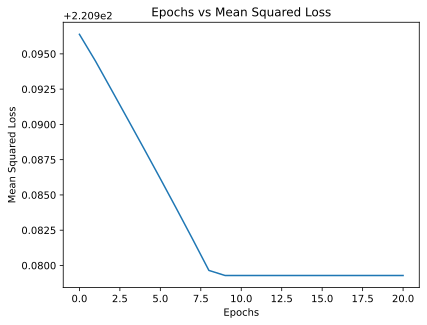

In [18]:
# DO NOT EDIT
# TEST CODE FOR CHECKING THE FUNCTION.
weights1,bias1,weights2,bias2,weights3,bias3,weights4,bias4=main(X,Y,20,0.01)
# weights1,bias1,weights2,bias2,weights3,bias3,weights4,bias4=main(x_test,y_test,20,0.01)

### If your output is correct, your graph should look like this: